# MODEL TRAINED USING CODE FROM: https://www.kaggle.com/code/anmolys/segmentation-using-yolov8

In [ ]:
# Installing ultralytics
!pip install ultralytics
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 799.4/799.4 kB 13.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [ ]:
# Importing necessary libraries
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import random
import copy
import shutil
import numpy as np
import ipywidgets as widgets
import wandb

In [ ]:
# Importing YOLO
from ultralytics import YOLO

In [ ]:
wandb.login(key="8ff12cdd8496db2984a091baa9f0824f7ca90927")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ip_path = "/content/drive/MyDrive/NHAS/2024.6.25_datasets/SUIM"
train_images_path=os.path.join(ip_path, 'train_val'
                               ,'images')
test_images_path=os.path.join(ip_path, 'TEST'
                               ,'images')
train_masks_path=os.path.join(ip_path, 'train_val'
                               ,'masks')
test_masks_path=os.path.join(ip_path, 'TEST'
                               ,'masks')

In [ ]:
# Defining output train,val and test paths
op_path='/content/drive/MyDrive/NHAS/2024.7.5_yolo_evaluation'
op_labels_path=os.path.join(op_path, 'labels')
op_images_path=os.path.join(op_path, 'images')

op_images_trainpath=os.path.join(op_images_path, 'train')
op_images_valpath=os.path.join(op_images_path, 'val')
op_images_testpath=os.path.join(op_images_path, 'test')
op_labels_trainpath=os.path.join(op_labels_path, 'train')
op_labels_valpath=os.path.join(op_labels_path, 'val')
op_labels_testpath=os.path.join(op_labels_path, 'test')

In [ ]:
# Sorting images and masks
train_imgs_list=sorted(os.listdir(train_images_path))
train_masks_list=sorted(os.listdir(train_masks_path))

test_imgs_list=sorted(os.listdir(test_images_path))
test_masks_list=sorted(os.listdir(test_masks_path))

In [ ]:
test_masks_list=list(filter (lambda x: x.endswith('bmp'), test_masks_list))

In [ ]:
# Checking size of training images
total_images_train=len(train_imgs_list)
total_images_train

1525

In [ ]:
# Checking size of test images
total_images_test=len(test_imgs_list)
total_images_test

110

In [ ]:
def plot_image_and_mask():
    figure,axis = plt.subplots(1,2,figsize=(30,30))
    plt.axis('off')
    k=random.randint(0, total_images_train-1) # choosing any random image number

    img_path=os.path.join(train_images_path, train_imgs_list[k]) # defining image path
    mask_path=os.path.join(train_masks_path, train_masks_list[k]) # defining mask path

    img_title=os.path.basename(img_path) # extracting image filename from path
    mask_title=os.path.basename(mask_path) # extracting mask filename from path

    # displaying image and mask
    axis[0].imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    axis[0].set_title(img_title, fontsize=30)
    axis[0].set_xticks([])
    axis[0].set_yticks([])
    axis[1].imshow(cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2RGB))
    axis[1].set_title(mask_title, fontsize=30)
    axis[1].set_xticks([])
    axis[1].set_yticks([])

    plt.tight_layout()
    plt.show()

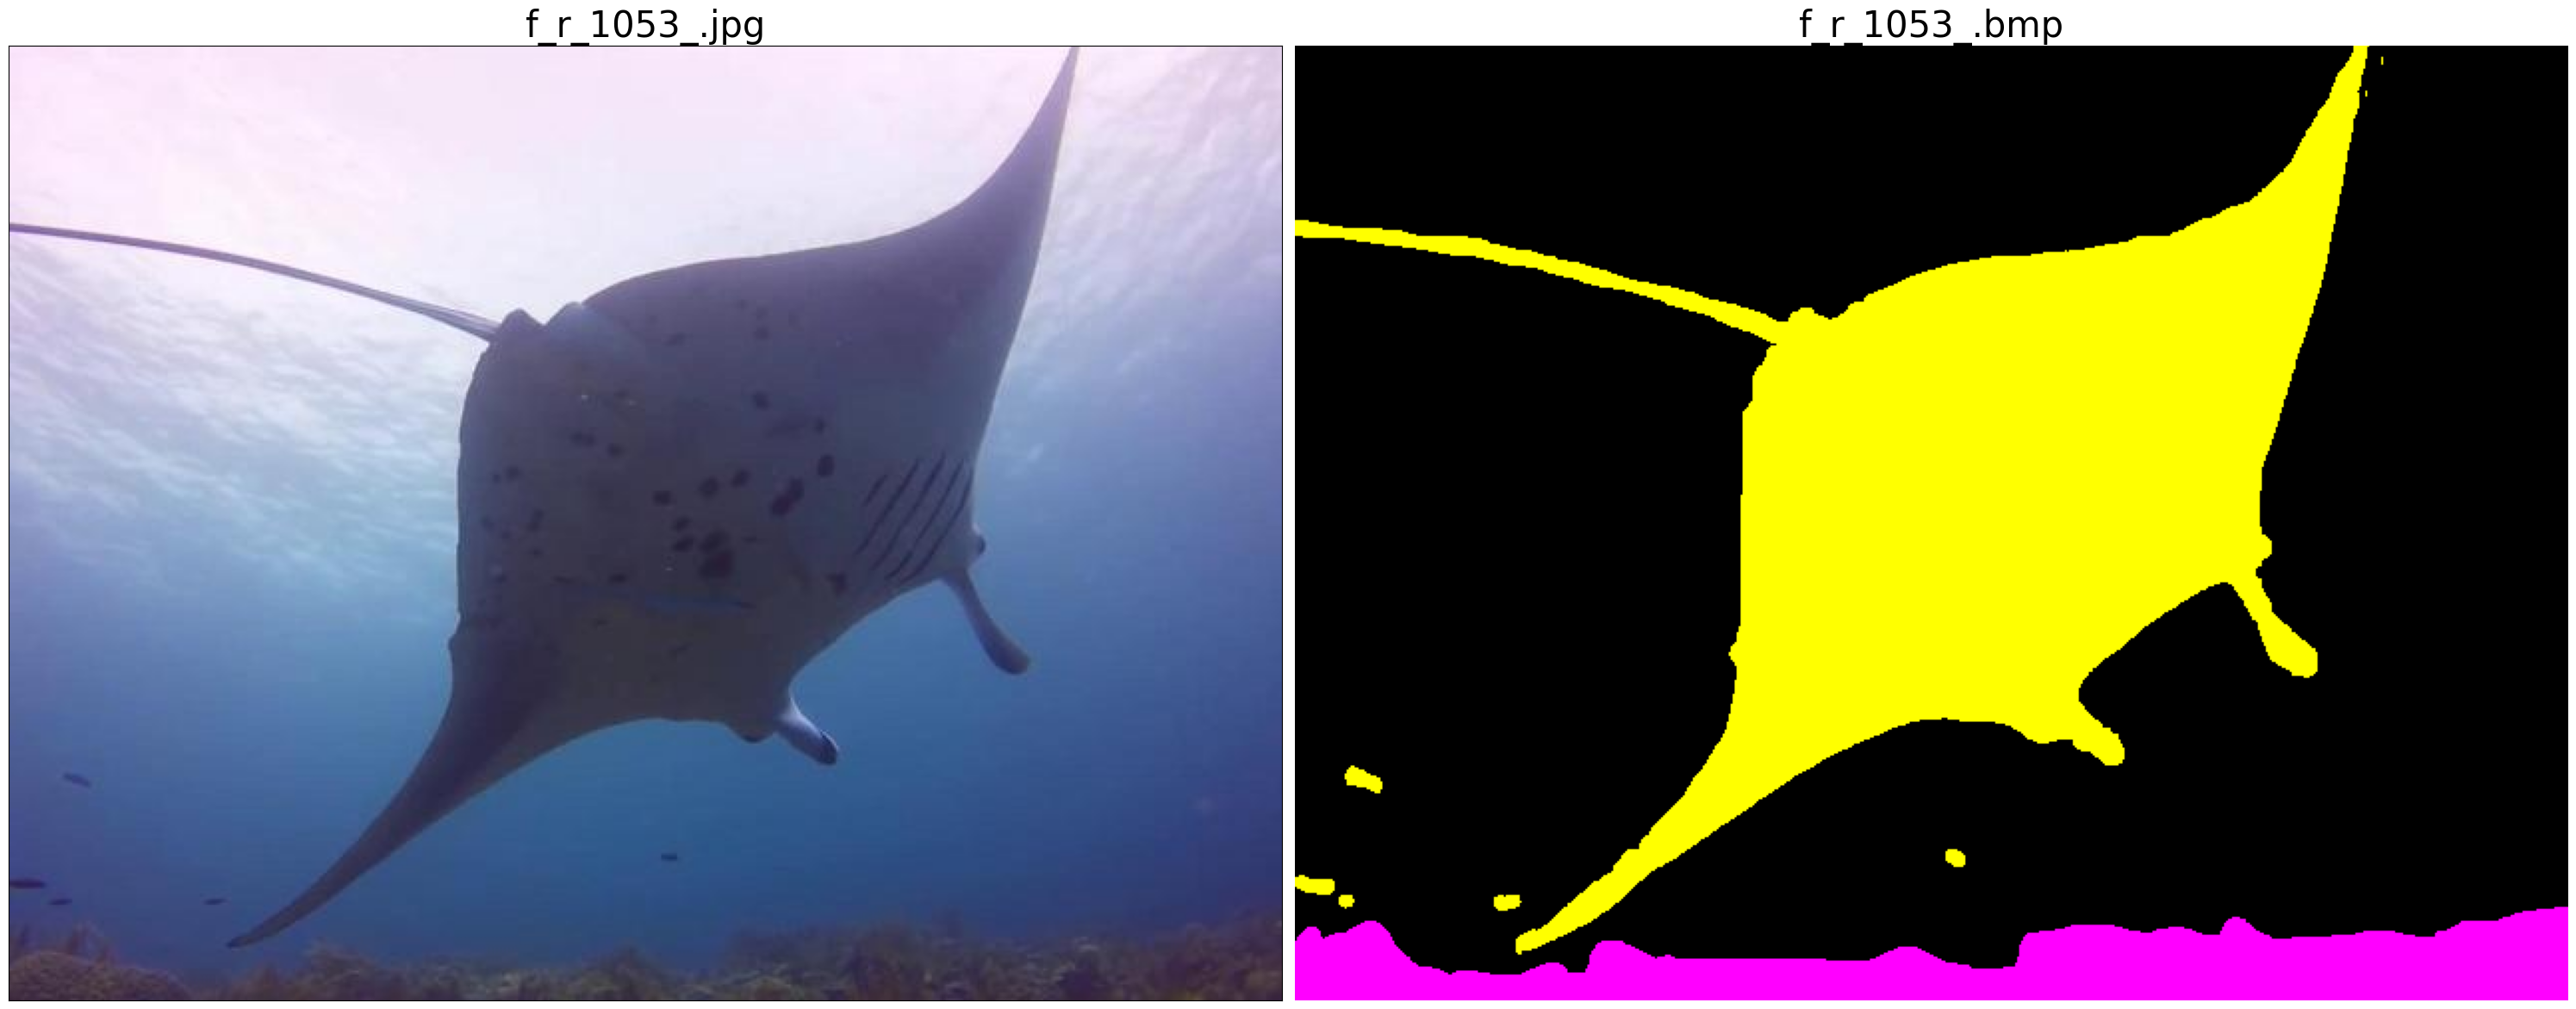

In [ ]:
plot_image_and_mask()

In [ ]:
# defining color-class mapping and color-name mapping
color_class_mapping={(0, 0, 0): 0,
                    (0, 0, 255): 1,
                    (0, 255, 0): 2,
                    (0, 255, 255): 3,
                    (255, 0, 0): 4,
                    (255, 0, 255): 5,
                    (255, 255, 0): 6,
                    (255, 255, 255): 7}

color_name_mapping={(0, 0, 0): 'black',
                    (0, 0, 255): 'blue',
                    (0, 255, 0): 'green',
                    (0, 255, 255): 'sky',
                    (255, 0, 0): 'red',
                    (255, 0, 255): 'pink',
                    (255, 255, 0): 'yellow',
                    (255, 255, 255): 'white'}

In [ ]:
# defining orange color to draw contour on mask
orange=(255,85,0)

In [ ]:
# function to draw contour around any random color present in the mask
def draw_contour_for_one_color_on_mask():
    figure,axis = plt.subplots(1,3,figsize=(30,30))
    plt.axis('off')
    k=random.randint(0, total_images_train-1) # choosing any random image

    img_path=os.path.join(train_images_path, train_imgs_list[k]) # defining image path
    img_title=os.path.basename(img_path) # extracting basename from path
    img=cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    mask_path=os.path.join(train_masks_path, train_masks_list[k]) # defining mask path
    mask_title=os.path.basename(mask_path) # extracting basename from path
    mask=cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2RGB)

    mask_copy=copy.deepcopy(mask) # creating a copy of mask to draw contour
    pixels = mask.reshape((-1, 3))
    unique_colors = np.unique(pixels, axis=0) # getting unique colors present in mask

    #getting only those unique colors which are defined in problem
    unique_colors_defined = [value for value in unique_colors if tuple(value) in color_class_mapping]
    unique_colors_defined = np.array(unique_colors_defined, dtype=np.uint8)
    total_colors=len(unique_colors_defined)
    j=random.randint(0, total_colors-1) # selecting any random color among all the defined colors present in mask
    color=unique_colors_defined[j]
    # defining title for contour on mask
    mask_copy_title=os.path.basename(mask_path)+' with contour on color ' +str(color_name_mapping[tuple(color)])

    mask_mask = cv2.inRange(mask, color, color) # getting mask of the selcted color on the mask-image
    contours, hrc = cv2.findContours(mask_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) # finding contours
    cv2.drawContours(mask_copy, contours, -1, orange, 4) # drawing contours

    axis[0].imshow(img) # displaying image
    axis[0].set_title(img_title, fontsize=30)
    axis[0].set_xticks([])
    axis[0].set_yticks([])
    axis[1].imshow(mask) # displaying mask
    axis[1].set_title(mask_title, fontsize=30)
    axis[1].set_xticks([])
    axis[1].set_yticks([])
    axis[2].imshow(mask_copy) # displaying copy of mask with contour
    axis[2].set_title(mask_copy_title, fontsize=30)
    axis[2].set_xticks([])
    axis[2].set_yticks([])

    plt.tight_layout()
    plt.show()

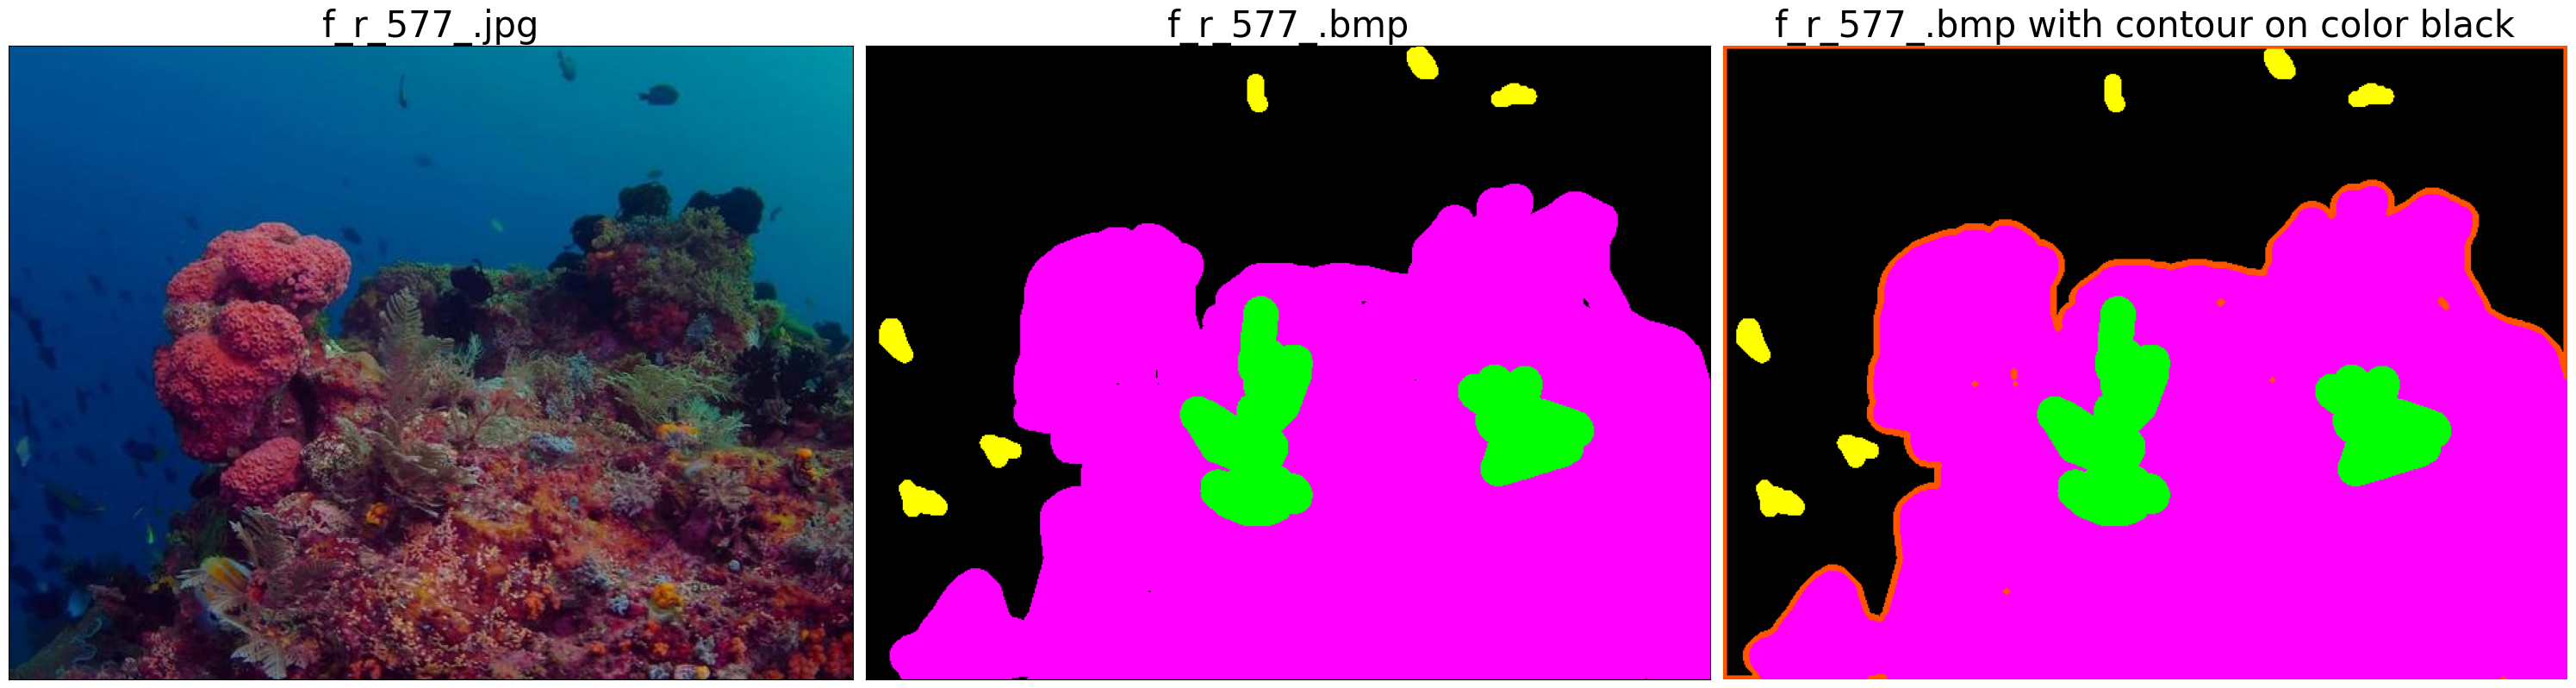

In [ ]:
draw_contour_for_one_color_on_mask()

In [ ]:
def write_polygon_file(class_contour_mapping, H, W, output_path, img_name):
    coordinates={}
    for obj in class_contour_mapping: # looping through all colors present in the mask
        polygons = []
        for cnt in class_contour_mapping[obj]: # looping through all contours present in the color
            if cv2.contourArea(cnt) > 20: # neglecting very small contours
                polygon = []
                for point in cnt: # looping through all points present in the contour
                    x, y = point[0]
                    polygon.append(round(x / W, 4))
                    polygon.append(round(y / H, 4))
                polygons.append(polygon)
        coordinates[obj]=polygons

    # creating text file for all contours of all colors present in mask
    with open('{}.txt'.format(os.path.join(output_path, img_name)), 'w') as f:
        for obj in coordinates:
            for polygon in coordinates[obj]:
                for p_, p in enumerate(polygon):
                    if p_ == len(polygon) - 1:  # if point is the last point in contour, need to give newline
                        f.write('{}\n'.format(p))
                    elif p_ == 0: # if point is the first point in contour, need to specify color also
                        f.write('{} {} '.format(obj, p))
                    else: # any other point between first and last
                        f.write('{} '.format(p))

In [ ]:
# defining progress bar for visualising progress of writing text files
progress_bar=widgets.FloatProgress(value=0, min=0, max=100, description='Progress',
                                   layout=widgets.Layout(width='100%'))
progress_bar

FloatProgress(value=0.0, description='Progress', layout=Layout(width='100%'))

In [ ]:
m=0 # for counting total number of labels created

for img in train_masks_list:

    image_path = os.path.join(train_masks_path,img)
    image = cv2.imread(image_path)  # Try to load the image

    if image is None:  # Check if image loading failed
        print(f"Warning: Failed to load image: {image_path}. Skipping.")
        continue  # Skip to the next image

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    pixels = image.reshape((-1, 3))
    unique_colors = np.unique(pixels, axis=0) # getting unique colors present in mask

    #getting only those unique colors which are defined in problem
    unique_colors_defined = [value for value in unique_colors if tuple(value) in color_class_mapping]
    unique_colors_defined = np.array(unique_colors_defined, dtype=np.uint8)
    total_colors=len(unique_colors_defined)

    img_name=os.path.splitext(img)[0] # extracting mask name
    img_full_name=img_name+'.jpg' # getting image name corresponding to the extracted mask name

    img_path=os.path.join(train_images_path, img_full_name) # getting image path
    shutil.copy(img_path, op_images_trainpath) # copying image to output train path

    H,W,_=image.shape # extracting mask dimensions
    class_contour_mapping={}

    for i in range(total_colors): # looping through all colors present in mask
        color=unique_colors_defined[i] # extracting the color
        class_code=color_class_mapping[tuple(color)] # getting color-code
        mask = cv2.inRange(image, color, color) # getting mask of color on the mask-image
        contours, hrc = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) # finding contours
        class_contour_mapping[class_code]=contours # mapping color-code to contours

    # writing label text file
    write_polygon_file(class_contour_mapping, H, W, op_labels_trainpath, img_name)
    m=m+1
    progress_bar.value=m/len(train_masks_list)*100    # updating progress bar

print("Total number of labels created: ", m)

KeyboardInterrupt: 

In [ ]:
# Restarting the progress bar to track the progress of test label files creation
progress_bar.value=0
progress_bar

In [ ]:
m=0
for img in test_masks_list:
    image_path = os.path.join(test_masks_path, img)
    image = cv2.imread(image_path)  # Try to load the image

    if image is None:  # Check if image loading failed
        print(f"Warning: Failed to load image: {image_path}. Skipping.")
        continue  # Skip to the next image

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    pixels = image.reshape((-1, 3))
    unique_colors = np.unique(pixels, axis=0)
    unique_colors_defined = [value for value in unique_colors if tuple(value) in color_class_mapping]
    unique_colors_defined = np.array(unique_colors_defined, dtype=np.uint8)
    total_colors=len(unique_colors_defined)
    img_name=os.path.splitext(img)[0]
    img_full_name=img_name+'.jpg'

    img_path=os.path.join(test_images_path, img_full_name)
    shutil.copy(img_path, op_images_testpath)

    H,W,_=image.shape
    class_contour_mapping={}
    for i in range(total_colors):
        color=unique_colors_defined[i]
        class_code=color_class_mapping[tuple(color)]
        mask = cv2.inRange(image, color, color)
        contours, hrc = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        class_contour_mapping[class_code]=contours

    write_polygon_file(class_contour_mapping, H, W, op_labels_testpath, img_name)
    m=m+1
    progress_bar.value=m/len(test_masks_list)*100


print("Total number of labels created: ", m)

In [ ]:
# function for creating validation dataset
def create_validation_data(dataset, size):
    random.shuffle(dataset)
    validation_data=dataset[:size]
    return validation_data


In [ ]:
# creating validation dataset of size 110 from training dataset
validation_datalist=create_validation_data(train_imgs_list, 110)

In [ ]:
for img in validation_datalist:
    imgsrc_path=os.path.join(op_images_trainpath, img)
    imgdst_path=os.path.join(op_images_valpath, img)
    shutil.move(imgsrc_path, imgdst_path)

    img_name=os.path.splitext(img)[0]
    label_file=img_name+'.txt'

    labelsrc_path=os.path.join(op_labels_trainpath,label_file)
    labeldst_path=os.path.join(op_labels_valpath,label_file)
    shutil.move(labelsrc_path, labeldst_path)

In [ ]:
# defining newline variable for config file
newline='\n'

In [ ]:
# defining lines of config text file

ln_1='# Train/val/test sets'+newline # starting with a comment line

# train, val and test path declaration
ln_2='train: ' +"'"+op_images_trainpath+"'"+newline
ln_3='val: ' +"'" + op_images_valpath+"'"+newline
ln_4='test: ' +"'" + op_images_testpath+"'"+newline
ln_5=newline

# names of the classes declaration
ln_6='names:'+newline
ln_7='  0: Background'+newline
ln_8='  1: Human divers'+newline
ln_9='  2: Aquatic plants and sea-grass'+newline
ln_10='  3: Wrecks and ruins'+newline
ln_11='  4: Robots'+newline
ln_12='  5: Reefs and invertebrates'+newline
ln_13='  6: Fish and vertebrates'+newline
ln_14='  7: Sea-floor and rocks'
config_lines=[ln_1, ln_2, ln_3, ln_4, ln_5, ln_6, ln_7, ln_8, ln_9, ln_10, ln_11, ln_12, ln_13, ln_14]

In [ ]:
# Creating path for config file
config_path=os.path.join('/content/drive/MyDrive/NHAS/2024.7.5_yolo_evaluation', 'config.yaml')
config_path

In [ ]:
# Writing config file
with open(config_path, 'w') as f:
    f.writelines(config_lines)

In [ ]:
# Choosing a YOLOv8 segmentation model for training with pretrained weights
model=YOLO('yolov8m-seg.yaml').load('yolov8m-seg.pt')

In [ ]:
# Training the model; here degrees, shear and perspective are augmentation arguments
results=model.train(data=config_path, epochs=100, degrees=60, shear=30, perspective=0.0005, boxes=False)

WARNING ⚠️ 'boxes' is deprecated and will be removed in in the future. Please use 'show_boxes' instead.
Ultralytics YOLOv8.2.49 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8m-seg.yaml, data=/content/drive/MyDrive/NHAS/2024.7.4_yolo_play/config.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_m

100%|██████████| 755k/755k [00:00<00:00, 22.4MB/s]


Overriding model.yaml nc=80 with nc=8

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

wandb: Currently logged in as: rennerelijah4 (rennerelijah4-University of Vermont). Use `wandb login --relogin` to force relogin


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.25M/6.25M [00:00<00:00, 115MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


AMP: checks passed ✅


train: Scanning /content/drive/.shortcut-targets-by-id/1w7MtOpeec700v95yxu-S6cNrXbQhN26L/NHAS/2024.7.4_yolo_play/labels/train... 1414 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1414/1414 [00:28<00:00, 49.23it/s]


train: New cache created: /content/drive/.shortcut-targets-by-id/1w7MtOpeec700v95yxu-S6cNrXbQhN26L/NHAS/2024.7.4_yolo_play/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/.shortcut-targets-by-id/1w7MtOpeec700v95yxu-S6cNrXbQhN26L/NHAS/2024.7.4_yolo_play/labels/val... 212 images, 0 backgrounds, 0 corrupt: 100%|██████████| 212/212 [00:30<00:00,  7.04it/s]


val: New cache created: /content/drive/.shortcut-targets-by-id/1w7MtOpeec700v95yxu-S6cNrXbQhN26L/NHAS/2024.7.4_yolo_play/labels/val.cache
Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      9.21G      1.376       3.01      2.195       1.53        132        640: 100%|██████████| 89/89 [01:54<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.16s/it]

                   all        212       2874      0.377      0.269      0.252      0.153       0.36      0.263      0.233      0.123



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100       8.6G      1.361      2.802       1.85       1.52         90        640: 100%|██████████| 89/89 [01:48<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.68s/it]


                   all        212       2874      0.542      0.233      0.209      0.116      0.521       0.22      0.191     0.0849

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      8.62G      1.391      2.829      1.854      1.528        125        640: 100%|██████████| 89/89 [01:50<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.31s/it]


                   all        212       2874      0.321      0.285      0.246      0.146      0.346      0.272      0.234      0.118

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      8.72G      1.378       2.79      1.792      1.524         56        640: 100%|██████████| 89/89 [01:51<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]


                   all        212       2874      0.375      0.315       0.27      0.166      0.343      0.278       0.25       0.13

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100       8.4G      1.356       2.76      1.733      1.507        160        640: 100%|██████████| 89/89 [01:52<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


                   all        212       2874      0.331      0.311      0.271      0.167      0.336      0.301      0.254      0.138

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      8.43G      1.325      2.676      1.689        1.5         84        640: 100%|██████████| 89/89 [01:54<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.19s/it]

                   all        212       2874      0.481      0.316       0.33      0.209      0.467      0.308      0.311      0.173



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      8.63G      1.295      2.631      1.627      1.472        159        640: 100%|██████████| 89/89 [01:54<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.14it/s]

                   all        212       2874      0.419      0.332       0.32      0.201       0.44      0.301      0.307      0.173



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      8.59G      1.272      2.591      1.595      1.447        172        640: 100%|██████████| 89/89 [01:53<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.21it/s]

                   all        212       2874      0.424      0.338      0.321      0.205      0.417      0.331      0.305      0.165



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      8.77G      1.257      2.573      1.582      1.446        124        640: 100%|██████████| 89/89 [01:53<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.20it/s]

                   all        212       2874       0.57      0.334      0.327      0.218      0.554      0.322       0.31      0.183



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      8.32G       1.25      2.533      1.573      1.443        152        640: 100%|██████████| 89/89 [01:53<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.11it/s]

                   all        212       2874      0.529       0.38      0.362      0.236      0.516      0.369      0.348        0.2



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      8.53G      1.243      2.501      1.521      1.424         74        640: 100%|██████████| 89/89 [01:54<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.17it/s]

                   all        212       2874      0.494      0.338      0.355      0.231      0.459      0.333      0.338      0.195



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      8.37G      1.222      2.497      1.504      1.421        137        640: 100%|██████████| 89/89 [01:53<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.19it/s]

                   all        212       2874      0.473      0.344      0.361       0.24      0.478      0.328      0.351      0.206



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      8.57G      1.214      2.487      1.501      1.415        160        640: 100%|██████████| 89/89 [01:51<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


                   all        212       2874      0.586      0.357       0.39      0.256      0.568      0.342      0.364       0.21

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      8.44G       1.21        2.5      1.509      1.423        149        640: 100%|██████████| 89/89 [01:49<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


                   all        212       2874      0.512      0.362      0.368      0.242      0.488      0.349      0.347      0.203

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      8.47G      1.214      2.463      1.485       1.41        156        640: 100%|██████████| 89/89 [01:44<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.18it/s]


                   all        212       2874      0.489      0.382      0.377      0.251      0.458       0.37      0.362      0.215

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100       9.1G      1.179       2.41      1.446      1.394        151        640: 100%|██████████| 89/89 [01:50<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]

                   all        212       2874      0.549      0.373       0.39      0.261       0.54      0.363      0.374      0.221



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      8.55G      1.178      2.375      1.424      1.395         83        640: 100%|██████████| 89/89 [01:53<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]

                   all        212       2874       0.52      0.394      0.408      0.262      0.502      0.363      0.382      0.223



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      8.41G      1.174      2.376      1.411      1.382        207        640: 100%|██████████| 89/89 [01:51<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.26s/it]

                   all        212       2874      0.525      0.389      0.408      0.287      0.515      0.377      0.389      0.239



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      8.81G      1.173      2.357      1.393      1.379         90        640: 100%|██████████| 89/89 [01:54<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]

                   all        212       2874      0.557      0.407      0.419      0.286      0.557      0.399      0.407      0.237



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      8.74G      1.144      2.375      1.394      1.369        159        640: 100%|██████████| 89/89 [01:50<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]

                   all        212       2874      0.542      0.381      0.406      0.273      0.528      0.372      0.391      0.235



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      8.53G      1.161      2.349      1.387      1.369         98        640: 100%|██████████| 89/89 [01:53<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]


                   all        212       2874      0.566      0.405      0.441      0.306      0.554      0.393      0.425      0.257

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      8.91G      1.139      2.326      1.368      1.358        183        640: 100%|██████████| 89/89 [01:51<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]

                   all        212       2874      0.544      0.401      0.423      0.296      0.529      0.387      0.409      0.254



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      8.65G      1.161      2.354      1.381      1.373        159        640: 100%|██████████| 89/89 [01:53<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.24s/it]

                   all        212       2874      0.528      0.399      0.422      0.296       0.52       0.39      0.409      0.251



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      8.36G      1.134        2.3      1.336      1.359        137        640: 100%|██████████| 89/89 [01:54<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]


                   all        212       2874       0.57      0.416      0.433      0.307       0.55      0.403      0.417      0.259

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      8.67G      1.146       2.31      1.319      1.358        145        640: 100%|██████████| 89/89 [01:53<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.02s/it]

                   all        212       2874      0.491      0.442       0.44      0.308      0.547      0.399      0.426      0.262



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      8.68G      1.129      2.308      1.331      1.359        135        640: 100%|██████████| 89/89 [01:50<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]

                   all        212       2874      0.534      0.416      0.421      0.296      0.509      0.396      0.401      0.248



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      8.57G      1.127      2.265      1.305      1.346        175        640: 100%|██████████| 89/89 [01:54<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.21s/it]

                   all        212       2874      0.526      0.455      0.449      0.305      0.531      0.411      0.421      0.256



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      8.47G      1.116      2.242      1.281      1.343        107        640: 100%|██████████| 89/89 [01:50<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.32s/it]


                   all        212       2874      0.548      0.423      0.434      0.306      0.556      0.421      0.424      0.259

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      8.62G      1.123      2.274      1.299      1.354        124        640: 100%|██████████| 89/89 [01:52<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]


                   all        212       2874      0.558      0.435      0.467      0.319      0.567      0.438      0.461      0.284

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      8.81G      1.119       2.25      1.281      1.335        129        640: 100%|██████████| 89/89 [01:50<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.33s/it]

                   all        212       2874      0.606      0.455      0.477      0.323      0.602      0.428      0.457      0.279



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      8.62G      1.103      2.227      1.253      1.329        108        640: 100%|██████████| 89/89 [01:55<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.16it/s]

                   all        212       2874      0.598      0.428      0.448      0.318      0.576      0.428      0.432      0.266



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      8.83G      1.122      2.244      1.287      1.345         92        640: 100%|██████████| 89/89 [01:55<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.19it/s]

                   all        212       2874      0.658      0.433      0.477       0.34      0.618      0.422      0.454      0.291



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      8.68G      1.101      2.192      1.248      1.324        206        640: 100%|██████████| 89/89 [01:55<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.22it/s]

                   all        212       2874      0.513      0.453      0.468      0.323      0.504      0.447      0.456      0.275



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      8.83G      1.087      2.204      1.252      1.323        230        640: 100%|██████████| 89/89 [01:52<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.21s/it]

                   all        212       2874      0.594      0.453      0.479      0.339      0.585       0.44      0.463      0.291



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      8.27G      1.094      2.196      1.239      1.314        140        640: 100%|██████████| 89/89 [01:50<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.20s/it]

                   all        212       2874      0.573      0.434      0.468      0.337       0.62      0.417      0.454      0.286



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      8.58G      1.089      2.188      1.222      1.314        100        640: 100%|██████████| 89/89 [01:50<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.29s/it]

                   all        212       2874      0.663      0.424      0.491      0.356      0.655      0.417      0.478      0.304



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      8.89G      1.078       2.16       1.23       1.31        199        640: 100%|██████████| 89/89 [01:49<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.37s/it]


                   all        212       2874      0.568      0.493      0.482      0.334      0.572      0.473      0.468      0.293

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      8.68G      1.083      2.174      1.207      1.312         85        640: 100%|██████████| 89/89 [01:50<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        212       2874      0.588      0.492      0.501      0.363       0.59      0.468      0.488      0.308



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      8.89G      1.076      2.172      1.214      1.311        110        640: 100%|██████████| 89/89 [01:51<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.15s/it]


                   all        212       2874      0.573      0.478      0.479      0.339      0.598      0.441      0.461      0.288

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      8.67G      1.079      2.183      1.212      1.313         95        640: 100%|██████████| 89/89 [01:50<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.17s/it]

                   all        212       2874      0.679      0.432      0.498      0.352      0.679      0.429      0.486      0.301



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      8.59G      1.063      2.118       1.18      1.302         93        640: 100%|██████████| 89/89 [01:53<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.16s/it]


                   all        212       2874        0.6      0.459      0.476      0.339      0.607      0.447      0.465      0.293

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      8.51G      1.064      2.152      1.182      1.307         89        640: 100%|██████████| 89/89 [01:53<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.19s/it]

                   all        212       2874      0.663      0.438      0.503      0.357      0.647      0.439      0.482      0.304



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100       8.6G      1.059       2.14      1.179      1.295        166        640: 100%|██████████| 89/89 [01:53<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


                   all        212       2874      0.609      0.484      0.506      0.366      0.651       0.45      0.486      0.312

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      8.66G       1.06      2.135      1.175      1.294        176        640: 100%|██████████| 89/89 [01:48<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]

                   all        212       2874      0.605      0.465      0.489      0.355      0.599      0.462      0.477      0.301



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100       8.6G      1.072      2.112      1.158      1.293        130        640: 100%|██████████| 89/89 [01:56<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.06it/s]

                   all        212       2874      0.616      0.455      0.487      0.351      0.602      0.447      0.475      0.296



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      8.38G      1.048      2.089       1.15      1.285        118        640: 100%|██████████| 89/89 [01:52<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.13it/s]

                   all        212       2874      0.587      0.473      0.487      0.344       0.58      0.459      0.477      0.293



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      8.63G      1.044      2.087      1.143      1.289         96        640: 100%|██████████| 89/89 [01:53<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.24it/s]

                   all        212       2874      0.601      0.499      0.518       0.38      0.611      0.485      0.507      0.319



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100      8.81G      1.059      2.095      1.158      1.285        130        640: 100%|██████████| 89/89 [01:52<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.32s/it]

                   all        212       2874       0.62       0.48      0.509      0.369      0.607      0.471      0.492      0.317



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      8.44G      1.044      2.075      1.141      1.287        160        640: 100%|██████████| 89/89 [01:43<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.22it/s]

                   all        212       2874      0.647      0.482      0.518      0.375      0.654      0.473       0.51      0.326



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      8.51G      1.034      2.073      1.123      1.276        200        640: 100%|██████████| 89/89 [01:38<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.36s/it]

                   all        212       2874       0.66      0.491      0.526      0.387      0.657      0.485      0.512      0.333



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100      8.49G      1.038      2.053      1.119      1.272        150        640: 100%|██████████| 89/89 [01:43<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]


                   all        212       2874      0.565      0.494      0.505      0.363      0.566      0.473      0.487      0.314

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100      8.69G      1.032      2.071      1.109      1.277        125        640: 100%|██████████| 89/89 [01:45<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.18it/s]

                   all        212       2874       0.64      0.489      0.521      0.378      0.659      0.473      0.509      0.326



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      8.88G       1.04      2.061      1.118      1.276        103        640: 100%|██████████| 89/89 [01:37<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.32s/it]

                   all        212       2874       0.62      0.481      0.505      0.369      0.627      0.464      0.491      0.316



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      8.68G      1.028      2.035        1.1      1.272        308        640: 100%|██████████| 89/89 [01:39<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.20it/s]

                   all        212       2874      0.651      0.482      0.524      0.387      0.644      0.463      0.509      0.326



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100       8.8G      1.012      2.043      1.104      1.263        141        640: 100%|██████████| 89/89 [01:36<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.15it/s]

                   all        212       2874      0.607      0.493      0.525      0.375      0.704      0.444       0.51       0.32



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      8.43G       1.03      2.038        1.1      1.266        184        640: 100%|██████████| 89/89 [01:36<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.36s/it]

                   all        212       2874      0.657      0.487      0.529      0.379      0.655      0.478      0.511      0.324



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100       8.7G      1.022      2.019      1.079      1.262        119        640: 100%|██████████| 89/89 [01:37<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.12it/s]

                   all        212       2874      0.595      0.496      0.529      0.379      0.615       0.47      0.504      0.325



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100      8.97G      1.019      2.018      1.072      1.262        186        640: 100%|██████████| 89/89 [01:37<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.38s/it]

                   all        212       2874      0.652      0.477      0.518      0.379       0.65      0.475       0.51      0.326



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      8.45G      1.014       2.02      1.074      1.258         75        640: 100%|██████████| 89/89 [01:38<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.20it/s]

                   all        212       2874      0.629      0.502      0.533      0.386      0.613      0.487      0.513      0.328



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100       8.5G      1.006      2.007      1.053      1.245        110        640: 100%|██████████| 89/89 [01:38<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.26s/it]

                   all        212       2874      0.667      0.493      0.536      0.388      0.641      0.477      0.516      0.329



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      8.96G      1.015      2.019      1.063      1.253        149        640: 100%|██████████| 89/89 [01:39<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.21it/s]

                   all        212       2874      0.653      0.515      0.532      0.389       0.65      0.508      0.518      0.335



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      8.52G          1      1.949      1.038      1.243         83        640: 100%|██████████| 89/89 [01:37<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]

                   all        212       2874      0.601      0.531      0.534      0.385      0.596      0.514      0.518      0.328



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100      8.74G     0.9919      1.982      1.052      1.255        119        640: 100%|██████████| 89/89 [01:36<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.27s/it]


                   all        212       2874       0.65      0.521      0.538      0.388      0.642      0.505      0.524      0.326

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100      9.22G       1.01      1.993       1.03      1.249        174        640: 100%|██████████| 89/89 [01:39<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.23it/s]


                   all        212       2874       0.65      0.527      0.546      0.399      0.634      0.514      0.529      0.341

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100      8.66G      0.991      1.961      1.033      1.244        130        640: 100%|██████████| 89/89 [01:36<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.14s/it]

                   all        212       2874      0.682      0.518      0.547      0.397      0.663      0.509      0.538       0.34



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100      8.68G     0.9868       1.94      1.017      1.236        109        640: 100%|██████████| 89/89 [01:38<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.21it/s]

                   all        212       2874      0.665      0.543      0.546      0.399      0.647      0.527      0.525      0.334



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      8.57G     0.9913      1.952      1.014      1.236        109        640: 100%|██████████| 89/89 [01:38<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


                   all        212       2874      0.693      0.533      0.561      0.421       0.73      0.514      0.552      0.357

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100      8.71G      0.998      1.935      1.004      1.235        139        640: 100%|██████████| 89/89 [01:41<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.21it/s]

                   all        212       2874       0.67      0.534      0.553      0.408      0.692      0.523      0.545      0.347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100      8.84G     0.9856       1.94      1.005      1.235        181        640: 100%|██████████| 89/89 [01:37<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.27s/it]


                   all        212       2874      0.684      0.523      0.554        0.4      0.667      0.507       0.53      0.341

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100       8.8G     0.9758      1.906     0.9876      1.227        104        640: 100%|██████████| 89/89 [01:38<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.03s/it]

                   all        212       2874      0.668      0.539      0.556      0.402       0.65       0.52      0.535      0.347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100      8.88G     0.9722        1.9     0.9834      1.228        181        640: 100%|██████████| 89/89 [01:39<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.03it/s]

                   all        212       2874      0.664      0.535      0.539      0.396      0.661      0.529      0.531      0.341



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100      8.49G     0.9849      1.943      1.003      1.237        114        640: 100%|██████████| 89/89 [01:38<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.16s/it]

                   all        212       2874      0.653       0.54      0.551       0.41      0.647      0.531      0.539      0.351



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100      8.51G     0.9715      1.904     0.9811      1.224        110        640: 100%|██████████| 89/89 [01:40<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.18it/s]

                   all        212       2874      0.688      0.537      0.563      0.423      0.669      0.523      0.543      0.358



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100      8.55G     0.9753      1.908      0.972      1.216        189        640: 100%|██████████| 89/89 [01:38<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.23it/s]

                   all        212       2874      0.688      0.527      0.559      0.411      0.671      0.515      0.542      0.348



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100      8.77G     0.9689      1.888     0.9643      1.219        248        640: 100%|██████████| 89/89 [01:38<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.20it/s]

                   all        212       2874      0.669      0.562      0.571       0.43      0.657      0.538      0.549      0.364



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100      8.36G     0.9658      1.863     0.9496      1.218        125        640: 100%|██████████| 89/89 [01:37<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.16s/it]

                   all        212       2874      0.692      0.547      0.567      0.417      0.689      0.526      0.545      0.354



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100      8.79G     0.9611      1.853     0.9384      1.208        110        640: 100%|██████████| 89/89 [01:39<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]

                   all        212       2874       0.67       0.56      0.577      0.433        0.7      0.522      0.554      0.364



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100      8.48G     0.9524       1.87     0.9495      1.212        161        640: 100%|██████████| 89/89 [01:35<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.17s/it]

                   all        212       2874      0.691      0.554      0.578      0.428       0.68      0.541      0.557      0.366



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100       8.5G     0.9461      1.863     0.9468      1.212        193        640: 100%|██████████| 89/89 [01:37<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.28s/it]

                   all        212       2874      0.677      0.559      0.578      0.428      0.667       0.54      0.556      0.364



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100      8.86G     0.9584      1.856     0.9283      1.209         98        640: 100%|██████████| 89/89 [01:39<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.16it/s]

                   all        212       2874      0.664      0.568      0.568      0.424      0.656      0.561      0.558      0.361



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100      8.46G     0.9269      1.818     0.9128      1.202        112        640: 100%|██████████| 89/89 [01:37<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]

                   all        212       2874      0.673      0.547      0.573      0.425      0.675      0.531      0.554      0.364



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100      8.63G     0.9659      1.861     0.9248      1.203        197        640: 100%|██████████| 89/89 [01:41<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.42s/it]

                   all        212       2874      0.724      0.536      0.577      0.427      0.714      0.526      0.565      0.366



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100      8.37G     0.9528      1.856     0.9235      1.208        155        640: 100%|██████████| 89/89 [01:43<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.03it/s]

                   all        212       2874      0.734      0.533      0.581      0.428       0.72      0.516      0.561      0.367



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100       8.8G     0.9464      1.841     0.9063      1.203        208        640: 100%|██████████| 89/89 [01:41<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.21s/it]

                   all        212       2874      0.774      0.514      0.579       0.43      0.758      0.502      0.558      0.368



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100      8.55G     0.9243      1.812     0.8931       1.19        159        640: 100%|██████████| 89/89 [01:42<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.33s/it]


                   all        212       2874      0.625      0.578      0.579      0.438      0.721      0.514      0.568      0.373

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100      8.58G     0.9435      1.805     0.8973      1.191        111        640: 100%|██████████| 89/89 [01:41<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.35s/it]

                   all        212       2874      0.691      0.574      0.583       0.44       0.72      0.541      0.567      0.374



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100      8.47G      0.919      1.798     0.8821      1.185        168        640: 100%|██████████| 89/89 [01:42<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.11it/s]

                   all        212       2874      0.729      0.563      0.587      0.445       0.72      0.554      0.579      0.384



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100      9.54G     0.9277      1.784     0.8783      1.182         94        640: 100%|██████████| 89/89 [01:43<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


                   all        212       2874      0.747      0.557      0.591      0.442      0.737      0.542      0.577       0.38

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100      8.63G     0.9321      1.795     0.8779       1.19        135        640: 100%|██████████| 89/89 [01:42<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.16it/s]

                   all        212       2874      0.691      0.569      0.581      0.439      0.687      0.564      0.568      0.375



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100       8.5G     0.9316      1.821     0.8809      1.183        243        640: 100%|██████████| 89/89 [01:41<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.07it/s]

                   all        212       2874      0.732      0.568       0.59      0.443      0.702      0.559      0.574      0.379


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100      8.14G      1.059       1.96      0.991      1.241         53        640: 100%|██████████| 89/89 [01:20<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]

                   all        212       2874      0.717      0.572      0.588      0.446      0.717      0.564      0.579      0.378



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100      8.21G      1.039      1.894      0.916      1.229         67        640: 100%|██████████| 89/89 [01:14<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]

                   all        212       2874      0.714      0.595      0.593      0.451      0.728      0.557      0.576       0.38



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100      8.15G      1.029      1.887     0.8996      1.222         65        640: 100%|██████████| 89/89 [01:12<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.10s/it]

                   all        212       2874      0.758      0.567      0.595      0.454      0.747      0.547      0.578      0.379



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100      8.08G      1.021      1.855     0.8706      1.218         47        640: 100%|██████████| 89/89 [01:15<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.40it/s]

                   all        212       2874      0.768      0.547      0.599      0.457      0.764       0.54      0.584      0.386



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100         8G      1.016       1.86     0.8597      1.212         23        640: 100%|██████████| 89/89 [01:11<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


                   all        212       2874      0.731      0.577      0.601       0.46      0.748      0.549      0.583      0.387

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100      8.51G      1.028      1.865     0.8585      1.216         72        640: 100%|██████████| 89/89 [01:13<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.38it/s]

                   all        212       2874      0.769      0.575      0.603      0.458      0.742      0.579      0.589      0.389



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100      8.56G      1.016      1.857     0.8521      1.211         97        640: 100%|██████████| 89/89 [01:12<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]

                   all        212       2874      0.766      0.577      0.606      0.459      0.763      0.563      0.594      0.391



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100      8.54G      1.021      1.868      0.859      1.221        136        640: 100%|██████████| 89/89 [01:12<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]

                   all        212       2874      0.766      0.571      0.605      0.463       0.76      0.565      0.595      0.391



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100      8.03G      1.009      1.845     0.8466      1.214         82        640: 100%|██████████| 89/89 [01:13<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]

                   all        212       2874       0.76      0.572      0.607      0.464      0.751      0.565      0.595      0.392



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100      7.94G      1.019      1.852     0.8469      1.214         66        640: 100%|██████████| 89/89 [01:12<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.20s/it]

                   all        212       2874      0.748       0.58      0.608      0.464      0.743      0.572      0.597      0.393



100 epochs completed in 3.216 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.2.49 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8m-seg summary (fused): 245 layers, 27227016 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:20<00:00,  2.95s/it]


                   all        212       2874      0.748       0.58      0.607      0.461      0.743      0.572      0.596      0.392
            Background        173        723        0.8      0.415      0.472      0.358      0.818      0.423      0.464      0.307
          Human divers         58         93      0.901      0.881      0.902      0.776      0.901      0.881      0.905      0.659
Aquatic plants and sea-grass         26         91      0.476      0.495      0.357      0.189      0.447      0.462      0.307      0.122
      Wrecks and ruins         37         51      0.857      0.707      0.761      0.666      0.881      0.725      0.807       0.63
                Robots         12         15      0.688        0.6       0.62      0.483       0.69        0.6       0.62      0.403
Reefs and invertebrates        140        327      0.768      0.554      0.606      0.491      0.754      0.541      0.583      0.412
  Fish and vertebrates        142       1237      0.797      0

lr/pg0,▃███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg1,▃███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg2,▃███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
metrics/mAP50(B),▁▁▃▂▃▄▄▄▅▄▄▅▅▆▆▆▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇████
metrics/mAP50(M),▁▁▃▂▃▄▄▄▅▄▄▅▅▅▆▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇████
metrics/mAP50-95(B),▁▁▂▂▃▃▄▄▅▄▄▅▅▅▆▅▅▆▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇████
metrics/mAP50-95(M),▁▁▂▂▃▃▄▄▅▄▄▅▅▅▆▅▅▆▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████
metrics/precision(B),▂▁▃▃▄▅▅▄▅▄▄▅▅▅▆▅▅▅▅▆▅▆▆▆▆▆▇▇▆▇▆▇▇█▇▇▇███
metrics/precision(M),▁▁▃▂▃▅▄▄▄▄▄▅▅▅▆▅▅▅▅▆▅▆▆▅▆▆▇▆▆▆▇▆▇█▇▇▇███
metrics/recall(B),▁▁▂▂▂▃▃▄▄▄▄▄▄▅▄▅▅▅▅▆▆▆▆▆▆▇▇▆▇▇▇▇▇▆▇▇█▇██
metrics/recall(M),▁▁▂▃▃▃▃▄▄▄▄▅▅▅▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▆███▇██


In [ ]:
plt.figure(figsize=(30,30))
trainingresult_path=os.path.join('/content/drive/MyDrive/NHAS/2024.7.5_yolo_evaluation/segment', 'train')
results_png=cv2.imread(os.path.join(trainingresult_path,'results.png'))
plt.imshow(results_png)

In [ ]:
# function for evaluating model metrics map50
def evaluate_map50(trainedmodel, data_path, dataset='val'):
    metrics=trainedmodel.val(data=data_path, split=dataset)
    map50=round(metrics.seg.map50, 3)
    print("The mAP of model for all images on {0} dataset is {1}".format(dataset,map50))
    return metrics, map50

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# function for displaying plots created by YOLO
def display_curves(root_path):
    plt.figure(figsize=(50,50))

    #displaying mask p curve
    p_curve_path = os.path.join(root_path,'MaskP_curve.png')
    if os.path.exists(p_curve_path):  # Check if the file exists
        p_curve=cv2.imread(p_curve_path)
        if p_curve is not None:  # Check if the image was loaded successfully
            ax=plt.subplot(5,1,1)
            plt.imshow(p_curve)
        else:
            print(f"Error loading image: {p_curve_path}")
    else:
        print(f"File not found: {p_curve_path}")

    #displaying mask r curve
    r_curve_path = os.path.join(root_path,'MaskR_curve.png')
    if os.path.exists(r_curve_path):
        r_curve=cv2.imread(r_curve_path)
        if r_curve is not None:
            ax=plt.subplot(5,1,2)
            plt.imshow(r_curve)
        else:
            print(f"Error loading image: {r_curve_path}")
    else:
        print(f"File not found: {r_curve_path}")

    #displaying mask pr curve
    pr_curve_path = os.path.join(root_path,'MaskPR_curve.png')
    if os.path.exists(pr_curve_path):
        pr_curve=cv2.imread(pr_curve_path)
        if pr_curve is not None:
            ax=plt.subplot(5,1,3)
            plt.imshow(pr_curve)
        else:
            print(f"Error loading image: {pr_curve_path}")
    else:
        print(f"File not found: {pr_curve_path}")

    #displaying mask f1 curve
    f1_curve_path = os.path.join(root_path,'MaskF1_curve.png')
    if os.path.exists(f1_curve_path):
        f1_curve=cv2.imread(f1_curve_path)
        if f1_curve is not None:
            ax=plt.subplot(5,1,4)
            plt.imshow(f1_curve)
        else:
            print(f"Error loading image: {f1_curve_path}")
    else:
        print(f"File not found: {f1_curve_path}")

    #displaying confusion matrix
    confusion_matrix_path = os.path.join(root_path,'confusion_matrix.png')
    if os.path.exists(confusion_matrix_path):
        confusion_matrix=cv2.imread(confusion_matrix_path)
        if confusion_matrix is not None:
            ax=plt.subplot(5,1,5)
            plt.imshow(confusion_matrix)
        else:
            print(f"Error loading image: {confusion_matrix_path}")
    else:
        print(f"File not found: {confusion_matrix_path}")

In [ ]:
# Evaluating test metrics
test_metrics, test_map50=evaluate_map50(model, config_path, dataset='test')

In [ ]:
# Path storing model's performance on test dataset
test_path=os.path.join('/content/drive/MyDrive/NHAS/2024.7.5_yolo_evaluation', 'runs', 'segment', 'train') #val is a misnomer, it is actually measuring validation on test dataset

In [ ]:
# Display plots on test data
display_curves(test_path)

In [ ]:
plt.figure(figsize=(30,30))

for i in range(1,6,2):
    m=random.randint(0, len(test_imgs_list)) # Selecting random image number from test dataset
    test_image=os.path.join(op_images_testpath, os.listdir(test_images_path)[m])
    ax=plt.subplot(3,2,i)

    # Display actual image
    plt.imshow(cv2.cvtColor(cv2.imread(test_image), cv2.COLOR_BGR2RGB))
    plt.xticks([])
    plt.yticks([])
    plt.title("Actual image", fontsize = 40)

    # Predict
    res = model(test_image)
    res_plotted = res[0].plot()
    ax=plt.subplot(3,2,i+1)

    # Display image with predictions
    plt.imshow(res_plotted)
    plt.title("Image with predictions", fontsize = 40)
    plt.xticks([])
    plt.yticks([])

In [ ]:
model.save("yolo_segmentation_model.pt")

In [ ]:
res = model("/content/nido-robotics_2400x1160.jpg")
res_plotted = res[0].plot()

# Set figure size
plt.figure(figsize=(30, 15))  # Adjust width and height as needed

# Create subplot
ax = plt.subplot(3, 2, 1)

# Display image with predictions
plt.imshow(res_plotted)
plt.title("img with mask overlay", fontsize=40)
plt.xticks([])
plt.yticks([])

# Show the plot
plt.show()

NameError: name 'model' is not defined

# Presentation Evaluation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.0/800.0 kB 18.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import cv2
import os

In [ ]:
# Define color-class mapping and color-name mapping
color_class_mapping = {
    0: (0, 0, 0),
    1: (0, 0, 255),
    2: (0, 255, 0),
    3: (0, 255, 255),
    4: (255, 0, 0),
    5: (255, 0, 255),
    6: (255, 255, 0),
    7: (255, 255, 255)
}

color_name_mapping = {
    (0, 0, 0): 'black',
    (0, 0, 255): 'blue',
    (0, 255, 0): 'green',
    (0, 255, 255): 'sky',
    (255, 0, 0): 'red',
    (255, 0, 255): 'pink',
    (255, 255, 0): 'yellow',
    (255, 255, 255): 'white'
}


In [ ]:
image_path = "/content/drive/MyDrive/NHAS/2024.6.25_datasets/TEST/images/w_r_59_.jpg"
mask_path = image_path.replace("images", "masks").replace(".jpg", ".bmp")

In [ ]:
model = YOLO("/content/drive/MyDrive/NHAS/2024.7.5_yolo_evaluation/segment/train/weights/best.pt")

In [ ]:
def predict(image_path):
    results = model.predict(image_path, project="home/nice")
    return results

def create_labeled_mask(results, color_class_mapping):
    predicted_masks = results[0].masks.data  # Assuming results is a list with one prediction result
    predicted_classes = results[0].boxes.cls  # Assuming results[0].boxes.cls contains class indices

    predicted_masks = predicted_masks.cpu().numpy()
    predicted_classes = predicted_classes.cpu().numpy()

    height, width = predicted_masks.shape[1], predicted_masks.shape[2]
    labeled_mask = np.zeros((height, width), dtype=np.uint8)

    for i, mask in enumerate(predicted_masks):
        labeled_mask[mask > 0.5] = predicted_classes[i]

    rgb_labeled_mask = np.zeros((height, width, 3), dtype=np.uint8)
    for class_index, color in color_class_mapping.items():
        rgb_labeled_mask[labeled_mask == class_index] = color

    return rgb_labeled_mask

# Function to convert RGB to class index
def rgb_to_class_index(rgb_image, color_class_mapping):
    class_index_image = np.zeros(rgb_image.shape[:2], dtype=np.uint8)
    for class_idx, color in color_class_mapping.items():
        mask = np.all(rgb_image == color, axis=-1)
        class_index_image[mask] = class_idx
    return class_index_image

def compute_class_metrics(true_mask, pred_mask, num_classes, running_metrics):
    for class_idx in range(num_classes):
        tp = np.sum((pred_mask == class_idx) & (true_mask == class_idx))
        tn = np.sum((pred_mask != class_idx) & (true_mask != class_idx))
        fp = np.sum((pred_mask == class_idx) & (true_mask != class_idx))
        fn = np.sum((pred_mask != class_idx) & (true_mask == class_idx))

        running_metrics[class_idx]['TP'] += tp
        running_metrics[class_idx]['TN'] += tn
        running_metrics[class_idx]['FP'] += fp
        running_metrics[class_idx]['FN'] += fn

        # Accumulate intersection and union values
        running_metrics[class_idx]['Intersection'] += tp
        running_metrics[class_idx]['Union'] += (tp + fp + fn)

        # Calculate precision and recall
        precision = tp / (tp + fp) if (tp + fp) != 0 else 0
        recall = tp / (tp + fn) if (tp + fn) != 0 else 0
        running_metrics[class_idx]['Precision'] += precision
        running_metrics[class_idx]['Recall'] += recall


In [ ]:
# Initialize running metrics dictionary
num_classes = len(color_class_mapping)
running_metrics = {class_idx: {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0, 'Intersection': 0, 'Union': 0, 'Precision': 0, 'Recall': 0} for class_idx in range(num_classes)}

test_dataset_path = "/content/drive/MyDrive/NHAS/2024.6.25_datasets/TEST/images"

for image in os.listdir(test_dataset_path):
    image_path = os.path.join(test_dataset_path, image)
    mask_path = image_path.replace("images", "masks").replace(".jpg", ".bmp")

    results = predict(image_path)
    rgb_labeled_mask = create_labeled_mask(results, color_class_mapping)

    # Load ground truth mask for comparison
    gt_mask = cv2.imread(mask_path)

    if gt_mask is None:
        print(f"Warning: Could not read mask file for image {image_path}. Skipping this image.")
        continue

    gt_mask = cv2.cvtColor(gt_mask, cv2.COLOR_BGR2RGB)
    gt_mask = cv2.resize(gt_mask, (rgb_labeled_mask.shape[1], rgb_labeled_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Generate class masks for metrics calculation
    pred_class_mask = np.zeros((rgb_labeled_mask.shape[0], rgb_labeled_mask.shape[1]), dtype=np.uint8)
    for class_idx, color in color_class_mapping.items():
        pred_class_mask[np.all(rgb_labeled_mask == color, axis=-1)] = class_idx

    gt_class_mask = np.zeros((gt_mask.shape[0], gt_mask.shape[1]), dtype=np.uint8)
    for class_idx, color in color_class_mapping.items():
        gt_class_mask[np.all(gt_mask == color, axis=-1)] = class_idx

    true_rgb_mask = np.array(rgb_labeled_mask)
    pred_rgb_mask = np.array(Image.open(mask_path))

    if true_rgb_mask.shape != pred_rgb_mask.shape:
        print(f"Resizing predicted mask from {pred_rgb_mask.shape} to {true_rgb_mask.shape}")
        pred_rgb_mask = np.array(Image.fromarray(pred_rgb_mask).resize(true_rgb_mask.shape[1::-1], Image.NEAREST))

    # Convert RGB masks to class index masks
    true_class_mask = rgb_to_class_index(true_rgb_mask, color_class_mapping)
    pred_class_mask = rgb_to_class_index(pred_rgb_mask, color_class_mapping)

    # Compute metrics
    compute_class_metrics(true_class_mask, pred_class_mask, num_classes, running_metrics)

# Print total metrics for each class
for class_idx, class_metrics in running_metrics.items():
    color = color_class_mapping[class_idx]
    color_name = color_name_mapping[color]
    intersection = class_metrics['Intersection']
    union = class_metrics['Union']
    tp = class_metrics['TP']
    fp = class_metrics['FP']
    fn = class_metrics['FN']

    iou = intersection / union if union != 0 else 0
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0

    print(f'Class: {color_name} (Index: {class_idx})')
    print(f"TP: {class_metrics['TP']}, TN: {class_metrics['TN']}, FP: {class_metrics['FP']}, FN: {class_metrics['FN']}")
    print(f"IoU: {iou}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}\n")


image 1/1 /content/drive/MyDrive/NHAS/2024.6.25_datasets/TEST/images/f_r_2052_.jpg: 480x640 1 Background, 1 Human divers, 1 Reefs and invertebrates, 2 Fish and vertebratess, 4 Sea-floor and rockss, 35.0ms
Speed: 1.7ms preprocess, 35.0ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/drive/MyDrive/NHAS/2024.6.25_datasets/TEST/images/f_r_1428_.jpg: 480x640 2 Reefs and invertebratess, 10 Fish and vertebratess, 1 Sea-floor and rocks, 35.0ms
Speed: 1.7ms preprocess, 35.0ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/drive/MyDrive/NHAS/2024.6.25_datasets/TEST/images/d_r_58_.jpg: 480x640 2 Backgrounds, 1 Human divers, 1 Aquatic plants and sea-grass, 1 Sea-floor and rocks, 35.0ms
Speed: 1.5ms preprocess, 35.0ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/drive/MyDrive/NHAS/2024.6.25_datasets/TEST/images/f_r_209_.jpg: 480x640 2 Backgrounds, 1 Reefs and invertebrates, 17 Fish 